# Practice 3

Student 1: Alejandro González Álvarez

NIA 1: 252658

Student 2: Luca Franceschi

NIA 2: 253885

Student 3: Júlia Othats-Dalès

NIA 3: 254435

In [1]:
# !pip install torchinfo

In [18]:
import torch
import torchinfo
import torchvision
import torchsummary
import numpy as np
from PIL import Image
import torch.nn as nn
import scipy.io as sio
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as tf

# Google Drive (or not)

In [19]:
# Comment if not in Google Colab
# from google.colab import drive
# drive.mount('/content/drive')

# datadir = '/content/drive/My Drive/DeepLearning_2024/P3/Data/'
datadir = 'Data/'

# resultsdir = '/content/drive/My Drive/DeepLearning_2024/P3/Results/'
resultsdir = 'Results/'

# GPU Acceleration (or not)

In [20]:
# Print if gpu acceleration is enabled
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


# **SVHN Dataset**
In the following exercices, you will work with the SVHN dataset: http://ufldl.stanford.edu/housenumbers/

It contains RGB images of street digits labeled from 1 to 10 similar to the MNIST dataset.

The train and test sets are provided in the folder Data/svhn/ in .mat format.
In the following we show an example of how to load the images and labels from these files. A DataLoader for this dataset is provided in the code examples for the lab.

Label: 1


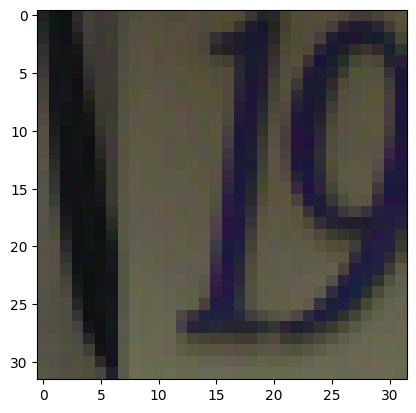

In [21]:
train_mat = sio.loadmat(datadir + 'svhn/train_32x32.mat')

images = train_mat['X']
labels = train_mat['y'].squeeze()

example_image, example_label = images[:,:,:,0], labels[0]
print('Label: ' + str(example_label))
plt.imshow(example_image)
plt.show()

# Ex. 1


1. Try to obtain the maximum test accuracy possible in the SVHN dataset. For this purpose train/test different variants of the CNN provided in P3-Part1-Examples. You can explore different strategies:
    - 1.1. Increase the size of the network by adding one ore more conv. layers. You can also increase the number of filters in each layer.
    - 1.2. Try different optimizers such as Adam or SGD with momentum and modify the learning rate. You can check: https://pytorch.org/docs/stable/optim.html
    - 1.3. Explore different random transformations during training ( Data augmentation ) such as random cropping with padding. You can check: https://pytorch.org/docs/stable/torchvision/transforms.html . Remember that these random transofrmation must not be used during testing.
    - 1.4 Whatever you consider...

2. Save all the different models , compare their test accuracy and analyse the results. Discuss what model has been shown more effective and why have you used the different strategies.

# Sol. 1

## The SVHN Dataset

In [22]:
#Data Loader
class SVHN(torch.utils.data.Dataset):

    def __init__(self, dataDir = datadir + 'svhn/train_32x32.mat', transform = None):
        mat = sio.loadmat(dataDir)
        self.data, self.labels = mat['X'], mat['y'].squeeze()
        self.transform = transform

        # We noticed that 0s were labeled as 10s
        self.labels[self.labels == 10] = 0

    def __getitem__(self, index):
        data = self.data[:,:,:,index]
        lbl = self.labels[index]

        data = Image.fromarray(data)
        # Apply a trasnformaiton to the image if it is indicated in the initalizer
        if self.transform is not None :
            data = self.transform(data)

        # return the image and the lab
        return data,lbl

    def __len__(self):
        return len(self.labels)

def mean_std(dataDir= datadir + 'svhn/train_32x32.mat'):
    mat = sio.loadmat(dataDir)
    data = mat['X']
    return data.mean(axis=(0,1,3)) / 255, data.std(axis=(0,1,3)) / 255

In [48]:
SVHN_mean, SVHN_std = mean_std()
print('Normalized dataset mean by channel', SVHN_mean)
print('Normalized dataset standard deviation by channel', SVHN_std)

tr = tf.Compose([
    tf.ToTensor(),
    tf.Normalize(mean = SVHN_mean, std = SVHN_std)
])

# Load train and test datasets
SVHNTrain = SVHN(datadir + 'svhn/train_32x32.mat', tr)
train_loader = torch.utils.data.DataLoader(dataset=SVHNTrain,
                                            batch_size=256,
                                            shuffle=True)

SVHNTest = SVHN(datadir + 'svhn/test_32x32.mat',tr)
test_loader = torch.utils.data.DataLoader(dataset=SVHNTest,
                                            batch_size=256,
                                            shuffle=True)

Normalized dataset mean by channel [0.4376821  0.4437697  0.47280442]
Normalized dataset standard deviation by channel [0.19803012 0.20101562 0.19703614]


In [24]:
total_step = len(SVHNTrain)
print(f'There are {total_step} samples in the training dataset')
print(f'There are {len(SVHNTest)} samples in the test dataset')

There are 73257 samples in the training dataset
There are 26032 samples in the test dataset


## ConvNet class

In [25]:
# Define an standard CNN -> Two conv. blocks and linear layer
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):

        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=5,  padding=2)
        #input : 3 channel, output 16 channel, filter size : 5x5

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3,  padding=1)
        #input : 16 channel, output 32 channel, filter size : 3x3

        self.fc = nn.Linear(8*8*32, num_classes)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def forward(self, x):

        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = out.reshape(out.size(0), -1) #128,64,2,2 -> 128,2*2*64
        out = self.fc(out) # we don't need sigmoid or other activation function at the end beacuse we will use nn.CrossEntropyLoss() (check documentation to understand why)

        return out

## Training and Testing functions

In [26]:
# Train function
def train(CNN, train_loader, optimizer, num_epochs=5, model_name='model.ckpt'):
    CNN.train() # Set the model in train mode
    losses_list = []
    criterion = nn.CrossEntropyLoss()
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        loss_sum = 0
        for images, labels in train_loader:
            # Get batch of samples and labels
            images = images.to(device)
            labels = labels.type(torch.LongTensor).to(device)

            # Forward pass
            outputs = CNN(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_sum += loss.cpu().item()
            losses_list.append(loss.cpu().item())

        loss_avg = loss_sum / len(train_loader)
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss_avg))

        # Save the model checkpoint
        torch.save(CNN.state_dict(), resultsdir + '/' + model_name)

    return losses_list

# Test funcion
def test(CNN, test_loader):
    CNN.eval() # Set the model in evaluation mode
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            # get network predictions
            outputs = CNN(images)

            # get predicted class
            _, predicted = torch.max(outputs.data, 1)

            # compare with the ground-truth
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # print and return accuracy
        print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))
        return 100 * correct / total

def plot_loss(losses_list, title):
    plt.figure(figsize=(10, 5))
    plt.plot(losses_list, linestyle='-', color='b')
    plt.title('Training Loss'+ title)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.ylim(0, 2.7)
    plt.show()

In [15]:
CNN = ConvNet().to(device)

#Initialize optimizer
learning_rate = .001
optimizer = torch.optim.Adam(CNN.parameters(), lr = learning_rate)

num_epochs = 5

Epoch [1/5], Loss: 0.9606
Epoch [2/5], Loss: 0.5363
Epoch [3/5], Loss: 0.4731
Epoch [4/5], Loss: 0.4263
Epoch [5/5], Loss: 0.3978


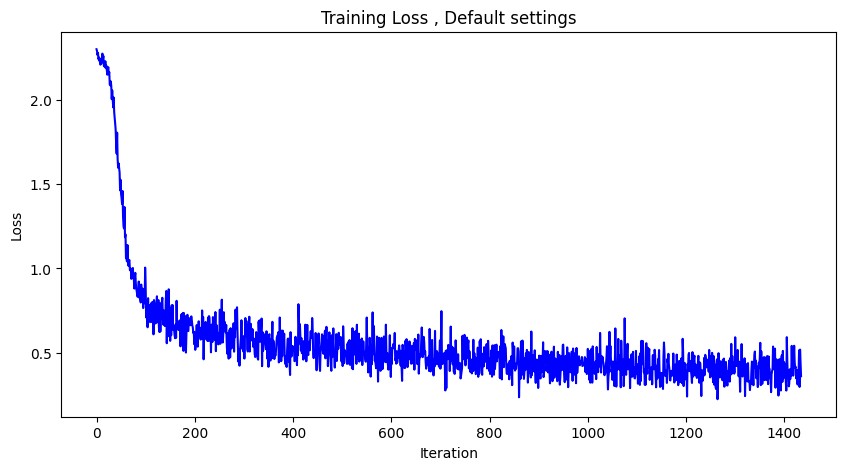

Test Accuracy of the model on the 10000 test images: 85.97111247695145 %


In [ ]:
loss_list = train(CNN, train_loader, optimizer, num_epochs, model_name='model_1_1.ckpt')
plot_loss(loss_list, " , Default settings")

CNN.load_state_dict(torch.load(resultsdir + 'model_1_1.ckpt'))

test_acc = test(CNN, test_loader)

## Testing with different changes


#### 2. Number of convolutional blocks

In [ ]:
#Increasing size of network (one more conv layer)
class TestingConvNet(nn.Module):
    def __init__(self, num_classes=10):

        super(TestingConvNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=5,  padding=2)
        #input : 3 channel, output 16 channel, filter size : 5x5

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3,  padding=1)
        #input : 16 channel, output 32 channel, filter size : 3x3

        self.conv3 = nn.Conv2d(32, 64, kernel_size=5,  padding=2) # (8 + 2*2 - 5)/1 + 1 = 8
        #input : 32 channel, output 64 channel, filter size : 5x5

        self.fc = nn.Linear(4*4*64, num_classes)

        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def forward(self, x):

        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.conv3(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = out.reshape(out.size(0), -1) #128,64,2,2 -> 128,2*2*64
        out = self.fc(out) # we don't need sigmoid or other activation function at the end beacuse we will use nn.CrossEntropyLoss() (check documentation to understand why)

        return out

In [ ]:
CNN = TestingConvNet().to(device)

learning_rate = .001
optimizer = torch.optim.Adam(CNN.parameters(),lr = learning_rate)

num_epochs = 5

Epoch [1/5], Loss: 0.9410
Epoch [2/5], Loss: 0.4515
Epoch [3/5], Loss: 0.3661
Epoch [4/5], Loss: 0.3167
Epoch [5/5], Loss: 0.2834


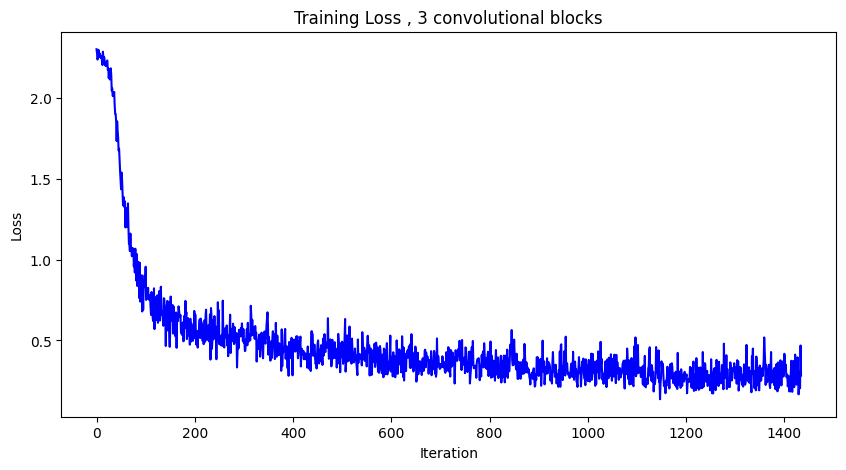

Test Accuracy of the model on the 10000 test images: 89.70497848801475 %


In [ ]:
loss_list = train(CNN, train_loader, optimizer, num_epochs, model_name='model_1_2_1.ckpt')
plot_loss(loss_list, " , 3 convolutional blocks")

CNN.load_state_dict(torch.load(resultsdir + 'model_1_2_1.ckpt'))

test_acc = test(CNN, test_loader)

In [ ]:
#Increasing size of network (two more conv layers)
class TestingConvNet(nn.Module):
    def __init__(self, num_classes=10):

        super(TestingConvNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=5,  padding=2)
        #input : 3 channel, output 16 channel, filter size : 5x5

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3,  padding=1)
        #input : 16 channel, output 32 channel, filter size : 3x3

        self.conv3 = nn.Conv2d(32, 64, kernel_size=5,  padding=2) # (8 + 2*2 - 5)/1 + 1 = 8
        #input : 32 channel, output 64 channel, filter size : 5x5

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3,  padding=1) # (4 + 2*1 - 3)/1 + 1 = 4
        #input : 64 channel, output 128 channel, filter size : 3x3

        self.fc = nn.Linear(2*2*128, num_classes)

        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def forward(self, x):

        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.conv3(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.conv4(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = out.reshape(out.size(0), -1) #128,64,2,2 -> 128,2*2*64
        out = self.fc(out) # we don't need sigmoid or other activation function at the end beacuse we will use nn.CrossEntropyLoss() (check documentation to understand why)

        return out

In [ ]:
CNN = TestingConvNet().to(device)

#Initialize optimizer
learning_rate = .001
optimizer = torch.optim.Adam(CNN.parameters(),lr = learning_rate)

num_epochs = 5

Epoch [1/5], Loss: 1.1346
Epoch [2/5], Loss: 0.4456
Epoch [3/5], Loss: 0.3452
Epoch [4/5], Loss: 0.2894
Epoch [5/5], Loss: 0.2546


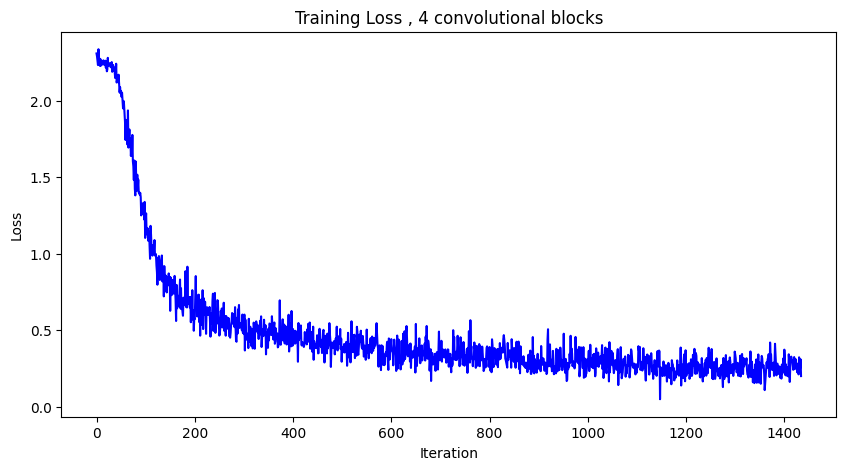

Test Accuracy of the model on the 10000 test images: 90.90350338045482 %


In [ ]:
loss_list = train(CNN, train_loader, optimizer, num_epochs, model_name='model_1_2_2.ckpt')
plot_loss(loss_list, " , 4 convolutional blocks")

CNN.load_state_dict(torch.load(resultsdir + 'model_1_2_2.ckpt'))

test_acc = test(CNN, test_loader)

In [ ]:
#Increasing size of network (three more conv layers)
class TestingConvNet(nn.Module):
    def __init__(self, num_classes=10):

        super(TestingConvNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=5,  padding=2)
        #input : 3 channel, output 16 channel, filter size : 5x5

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3,  padding=1)
        #input : 16 channel, output 32 channel, filter size : 3x3

        self.conv3 = nn.Conv2d(32, 64, kernel_size=5,  padding=2) # (8 + 2*2 - 5)/1 + 1 = 8
        #input : 32 channel, output 64 channel, filter size : 5x5

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3,  padding=1) # (4 + 2*1 - 3)/1 + 1 = 4
        #input : 64 channel, output 128 channel, filter size : 3x3

        self.conv5 = nn.Conv2d(128, 256, kernel_size=5,  padding=2) # (2 + 2*1 - 3)/1 + 1 = 2
        #input : 128 channel, output 256 channel, filter size : 5x5

        self.fc = nn.Linear(1*1*256, num_classes)

        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def forward(self, x):

        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.conv3(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.conv4(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.conv5(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = out.reshape(out.size(0), -1) #128,64,2,2 -> 128,2*2*64
        out = self.fc(out) # we don't need sigmoid or other activation function at the end beacuse we will use nn.CrossEntropyLoss() (check documentation to understand why)

        return out

In [ ]:
CNN = TestingConvNet().to(device)

learning_rate = .001
optimizer = torch.optim.Adam(CNN.parameters(),lr = learning_rate)

num_epochs = 5

Epoch [1/5], Loss: 1.4025
Epoch [2/5], Loss: 0.4511
Epoch [3/5], Loss: 0.3313
Epoch [4/5], Loss: 0.2753
Epoch [5/5], Loss: 0.2361


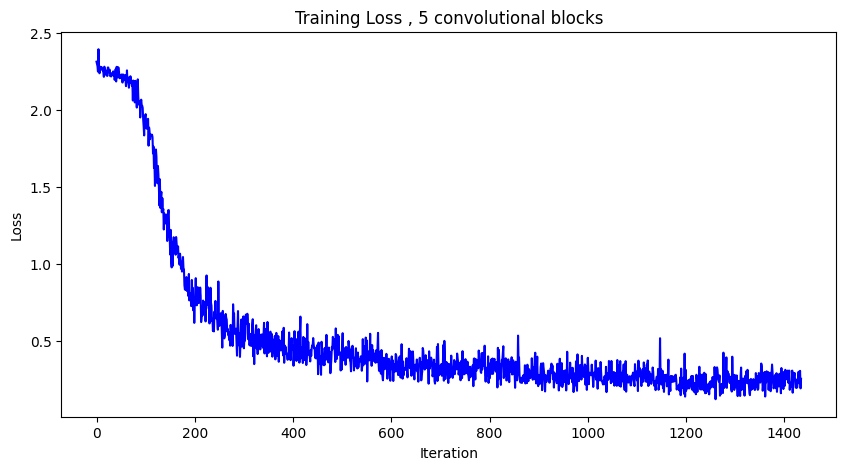

Test Accuracy of the model on the 10000 test images: 90.56161647203442 %


In [ ]:
loss_list = train(CNN, train_loader, optimizer, num_epochs, model_name='model_1_2_3.ckpt')
plot_loss(loss_list, " , 5 convolutional blocks")

CNN.load_state_dict(torch.load(resultsdir + 'model_1_2_3.ckpt'))

test_acc = test(CNN, test_loader)

#### 3. Optimizers

In [ ]:
optimizers = [(torch.optim.Adam, "Adam"),
              (torch.optim.SGD, "SGD")]

num_epochs = 5

Epoch [1/5], Loss: 0.9883
Epoch [2/5], Loss: 0.5384
Epoch [3/5], Loss: 0.4741
Epoch [4/5], Loss: 0.4299
Epoch [5/5], Loss: 0.3948


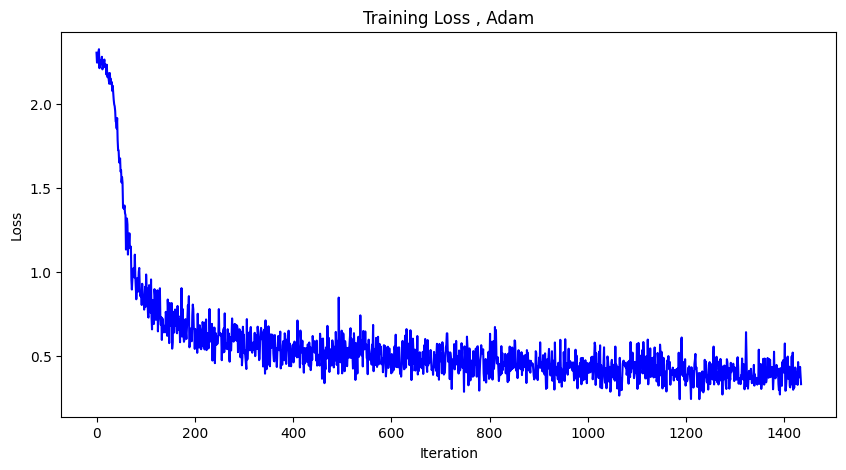

Test Accuracy of the model on the 10000 test images: 86.9199446834665 %
Epoch [1/5], Loss: 2.2267
Epoch [2/5], Loss: 2.0196
Epoch [3/5], Loss: 1.4845
Epoch [4/5], Loss: 1.0238
Epoch [5/5], Loss: 0.8013


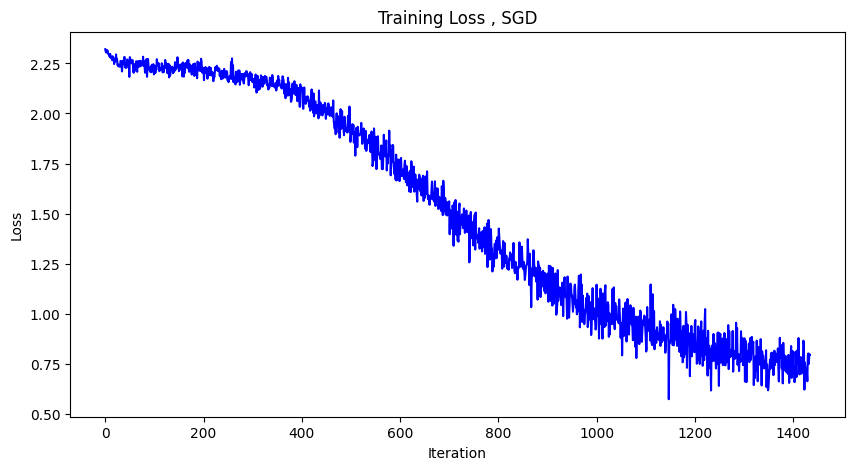

Test Accuracy of the model on the 10000 test images: 78.36508912108175 %


In [ ]:
for optimizer, label in optimizers:
    CNN = ConvNet().to(device)

    if (label == "Adam"):
        opt = optimizer(CNN.parameters(),lr = .001)
    if (label == "SGD"):
        opt = optimizer(CNN.parameters(), lr = .001, momentum = 0.9)

    loss_list = train(CNN, train_loader, opt, num_epochs, model_name='model_1_' + label + '.ckpt')

    title = " , " + label
    plot_loss(loss_list, title)

    CNN.load_state_dict(torch.load(resultsdir + 'model_1_' + label + '.ckpt'))

    test_acc = test(CNN, test_loader)

#### 4. Learning rate


In [ ]:
learning_rates = [.05, .01, .005, .001, .0005, .0001]

num_epochs = 5

Epoch [1/5], Loss: 3.3091
Epoch [2/5], Loss: 2.2389
Epoch [3/5], Loss: 2.2384
Epoch [4/5], Loss: 2.2388
Epoch [5/5], Loss: 2.2384


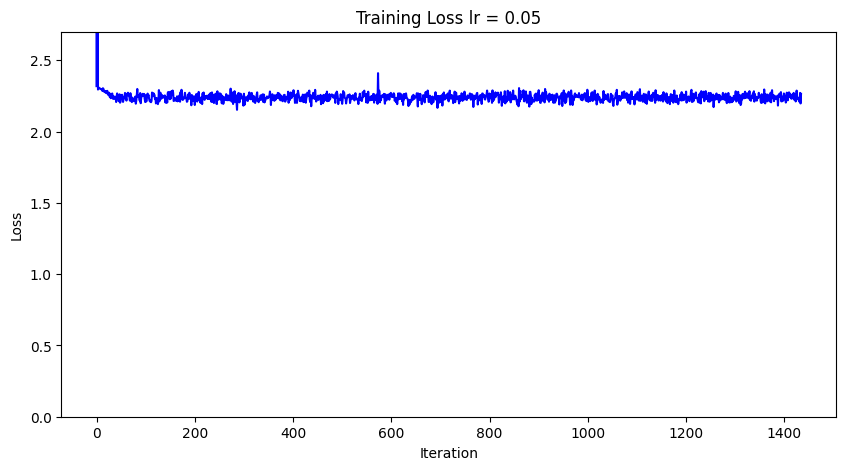

Test Accuracy of the model on the 10000 test images: 19.587430854333128 %
Epoch [1/5], Loss: 2.2584
Epoch [2/5], Loss: 2.2369
Epoch [3/5], Loss: 2.2366
Epoch [4/5], Loss: 2.2368
Epoch [5/5], Loss: 2.2369


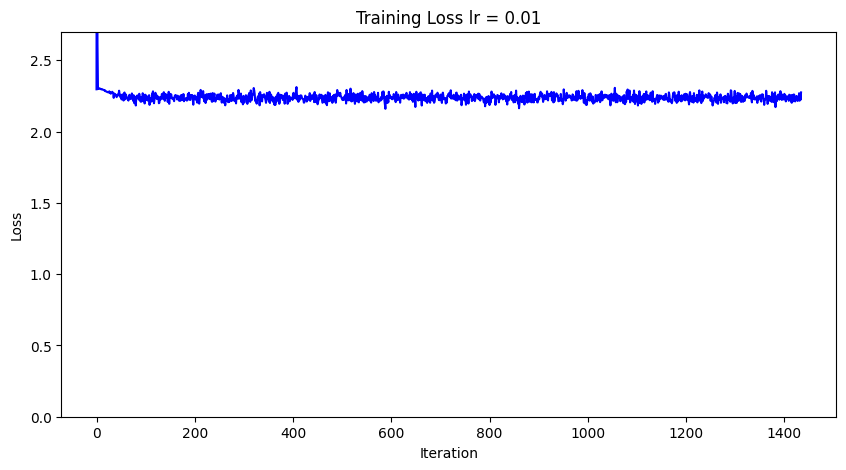

Test Accuracy of the model on the 10000 test images: 19.587430854333128 %
Epoch [1/5], Loss: 0.9361
Epoch [2/5], Loss: 0.5749
Epoch [3/5], Loss: 0.5353
Epoch [4/5], Loss: 0.5127
Epoch [5/5], Loss: 0.5051


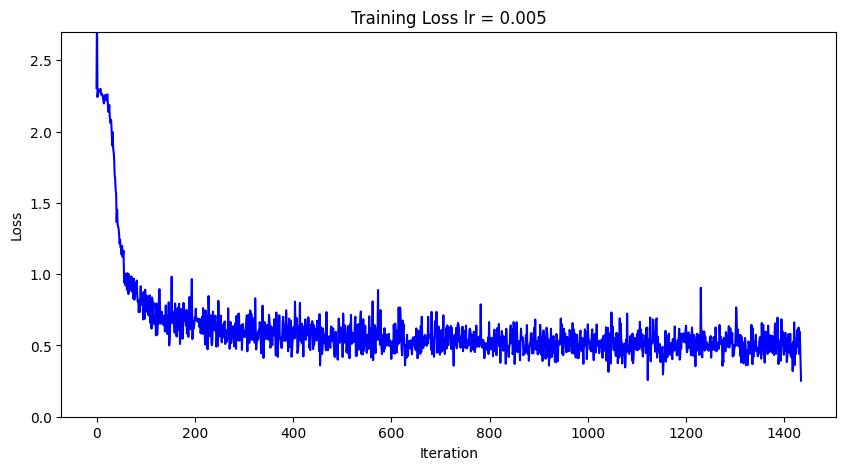

Test Accuracy of the model on the 10000 test images: 82.96327596803934 %
Epoch [1/5], Loss: 0.9725
Epoch [2/5], Loss: 0.5490
Epoch [3/5], Loss: 0.4822
Epoch [4/5], Loss: 0.4400
Epoch [5/5], Loss: 0.4064


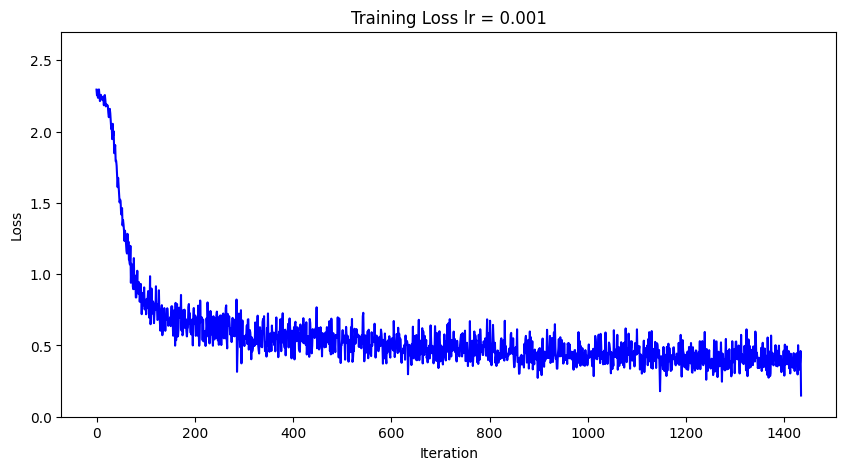

Test Accuracy of the model on the 10000 test images: 86.7778119237861 %
Epoch [1/5], Loss: 1.2081
Epoch [2/5], Loss: 0.6031
Epoch [3/5], Loss: 0.5411
Epoch [4/5], Loss: 0.5013
Epoch [5/5], Loss: 0.4740


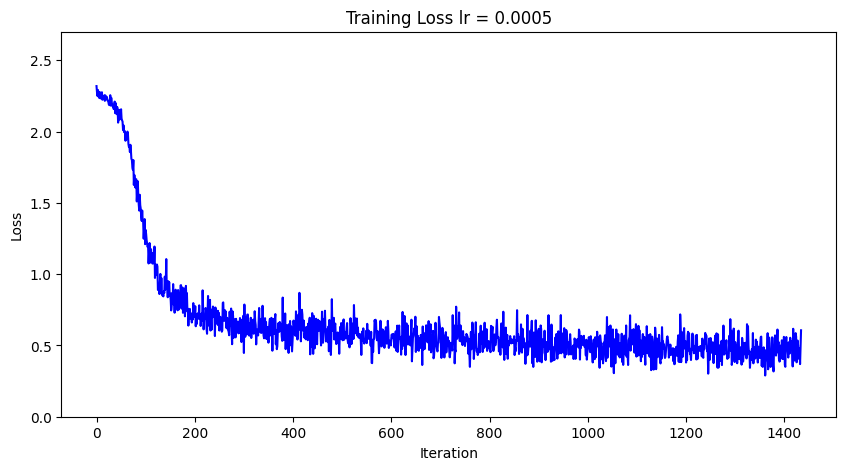

Test Accuracy of the model on the 10000 test images: 85.78672403196066 %
Epoch [1/5], Loss: 2.1103
Epoch [2/5], Loss: 1.2323
Epoch [3/5], Loss: 0.8350
Epoch [4/5], Loss: 0.7176
Epoch [5/5], Loss: 0.6594


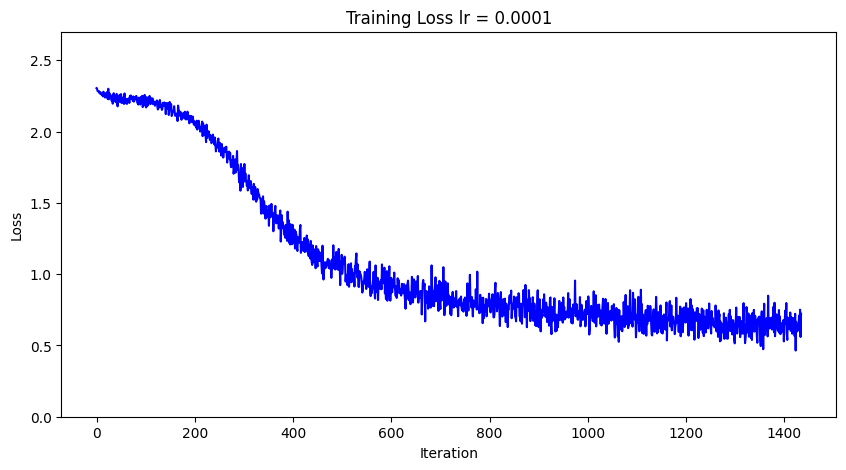

Test Accuracy of the model on the 10000 test images: 81.16933005531654 %


In [ ]:
for i, lr in enumerate(learning_rates):

    CNN = ConvNet()
    CNN = CNN.to(device)

    optimizer = torch.optim.Adam(CNN.parameters(),lr = lr)
    loss_list = train(CNN, train_loader, optimizer, num_epochs, model_name='model_1_lr' + str(i) + '.ckpt')

    title = " lr = " + str(lr)
    plot_loss(loss_list, title)

    CNN.load_state_dict(torch.load(resultsdir + 'model_1_lr' + str(i) + '.ckpt'))

    test_acc = test(CNN, test_loader)

#### 5. Number of channels

In [ ]:
#Increasing size of network (more channels)
class TestingConvNet(nn.Module):
    def __init__(self, num_classes=10):

        super(TestingConvNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=5,  padding=2) #32*32*3 --> 32*32*32
        #input : 3 channel, output 32 channel, filter size : 5x5

        self.conv2 = nn.Conv2d(32, 128, kernel_size=3,  padding=1) #16*16*32 --> 16*16*128
        #input : 32 channel, output 128 channel, filter size : 3x3

        self.fc = nn.Linear(8*8*128, num_classes)

        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def forward(self, x):

        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = out.reshape(out.size(0), -1) #128,64,2,2 -> 128,2*2*64
        out = self.fc(out) # we don't need sigmoid or other activation function at the end beacuse we will use nn.CrossEntropyLoss() (check documentation to understand why)

        return out

In [ ]:
CNN = TestingConvNet().to(device)

learning_rate = .001
optimizer = torch.optim.Adam(CNN.parameters(),lr = learning_rate)

num_epochs = 5

Epoch [1/5], Loss: 0.8429
Epoch [2/5], Loss: 0.4511
Epoch [3/5], Loss: 0.3678
Epoch [4/5], Loss: 0.3244
Epoch [5/5], Loss: 0.2858


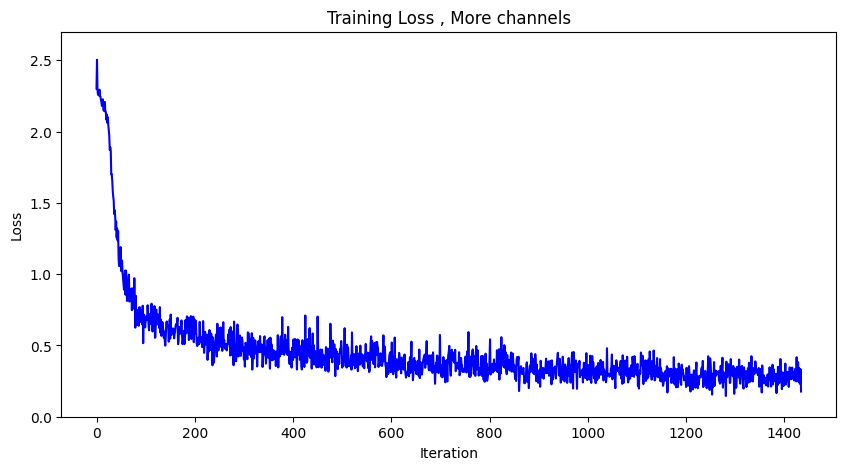

Test Accuracy of the model on the 10000 test images: 87.81883835279656 %


In [ ]:
loss_list = train(CNN, train_loader, optimizer, num_epochs, model_name='model_channels.ckpt')
plot_loss(loss_list, " , More channels")

CNN.load_state_dict(torch.load(resultsdir + 'model_channels.ckpt'))

test_acc = test(CNN, test_loader)

In [ ]:
#Increasing size of network (even more channels)
class TestingConvNet(nn.Module):
    def __init__(self, num_classes=10):

        super(TestingConvNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=5,  padding=2) #32*32*3 --> 32*32*32
        #input : 3 channel, output 32 channel, filter size : 5x5

        self.conv2 = nn.Conv2d(32, 128, kernel_size=3,  padding=1) #16*16*32 --> 16*16*128
        #input : 32 channel, output 128 channel, filter size : 3x3

        self.conv3 = nn.Conv2d(128, 512, kernel_size=3,  padding=1) #8*8*128 --> 8*8*512
        #input : 128 channel, output 512 channel, filter size : 3x3

        self.fc = nn.Linear(4*4*512, num_classes)

        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def forward(self, x):

        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.conv3(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = out.reshape(out.size(0), -1) #128,64,2,2 -> 128,2*2*64
        out = self.fc(out) # we don't need sigmoid or other activation function at the end beacuse we will use nn.CrossEntropyLoss() (check documentation to understand why)

        return out

In [ ]:
CNN = TestingConvNet().to(device)

learning_rate = .001
optimizer = torch.optim.Adam(CNN.parameters(),lr = learning_rate)

num_epochs = 5

Epoch [1/5], Loss: 0.8727
Epoch [2/5], Loss: 0.3483
Epoch [3/5], Loss: 0.2684
Epoch [4/5], Loss: 0.2171
Epoch [5/5], Loss: 0.1792


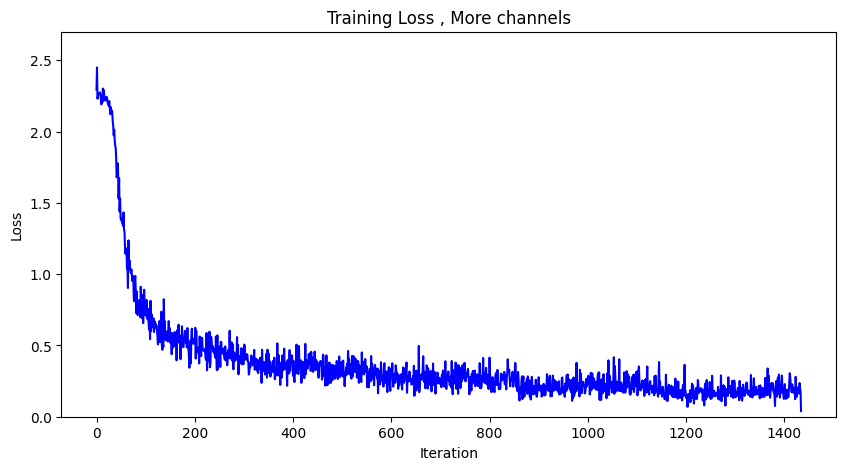

Test Accuracy of the model on the 10000 test images: 90.96496619545175 %


In [ ]:
loss_list = train(CNN, train_loader, optimizer, num_epochs, model_name='model_channels.ckpt')
plot_loss(loss_list, " , More channels")

CNN.load_state_dict(torch.load(resultsdir + 'model_channels.ckpt'))

test_acc = test(CNN, test_loader)

#### 6. Pooling Method


In [ ]:
#Strided Convolution
class TestingConvNet(nn.Module):
    def __init__(self, num_classes=10):

        super(TestingConvNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2, padding=2) #32*32*3 --> 16*16*16
        #input : 3 channel, output 32 channel, filter size : 5x5

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1) #16*16*16 --> 8*8*32
        #input : 32 channel, output 128 channel, filter size : 3x3

        self.fc = nn.Linear(8*8*32, num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):

        out = self.conv1(x)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.relu(out)

        out = out.reshape(out.size(0), -1) #128,64,2,2 -> 128,2*2*64
        out = self.fc(out) # we don't need sigmoid or other activation function at the end beacuse we will use nn.CrossEntropyLoss() (check documentation to understand why)

        return out

In [ ]:
CNN = TestingConvNet().to(device)

#Initialize optimizer
learning_rate = .001
optimizer = torch.optim.Adam(CNN.parameters(),lr = learning_rate)

num_epochs = 5

Epoch [1/5], Loss: 1.1728
Epoch [2/5], Loss: 0.6186
Epoch [3/5], Loss: 0.5278
Epoch [4/5], Loss: 0.4799
Epoch [5/5], Loss: 0.4441


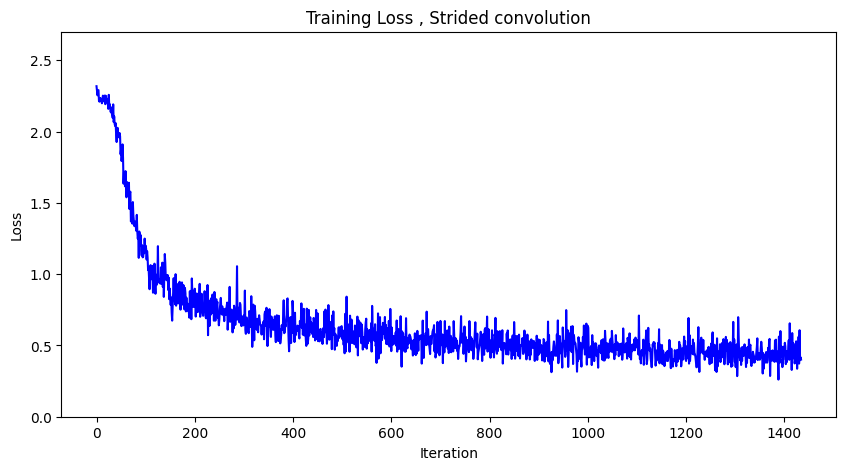

Test Accuracy of the model on the 10000 test images: 84.63045482483098 %


In [ ]:
loss_list = train(CNN, train_loader, optimizer, num_epochs, model_name='model_1_strided.ckpt')
plot_loss(loss_list, " , Strided convolution")

CNN.load_state_dict(torch.load(resultsdir + 'model_1_strided.ckpt'))

test_acc = test(CNN, test_loader)

In [ ]:
#Average Pooling
class TestingConvNet(nn.Module):
    def __init__(self, num_classes=10):

        super(TestingConvNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=2) #32*32*3 --> 16*16*16
        #input : 3 channel, output 32 channel, filter size : 5x5

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) #16*16*16 --> 8*8*32
        #input : 32 channel, output 128 channel, filter size : 3x3

        self.fc = nn.Linear(8*8*32, num_classes)
        self.avgpool = nn.AvgPool2d(kernel_size=2, stride=2)

        self.relu = nn.ReLU()

    def forward(self, x):

        out = self.conv1(x)
        out = self.relu(out)
        out = self.avgpool(out)

        out = self.conv2(out)
        out = self.relu(out)
        out = self.avgpool(out)

        out = out.reshape(out.size(0), -1) #128,64,2,2 -> 128,2*2*64
        out = self.fc(out) # we don't need sigmoid or other activation function at the end beacuse we will use nn.CrossEntropyLoss() (check documentation to understand why)

        return out

In [ ]:
CNN = TestingConvNet().to(device)

#Initialize optimizer
learning_rate = .001
optimizer = torch.optim.Adam(CNN.parameters(),lr = learning_rate)

num_epochs = 5

Epoch [1/5], Loss: 1.1324
Epoch [2/5], Loss: 0.5733
Epoch [3/5], Loss: 0.5022
Epoch [4/5], Loss: 0.4573
Epoch [5/5], Loss: 0.4230


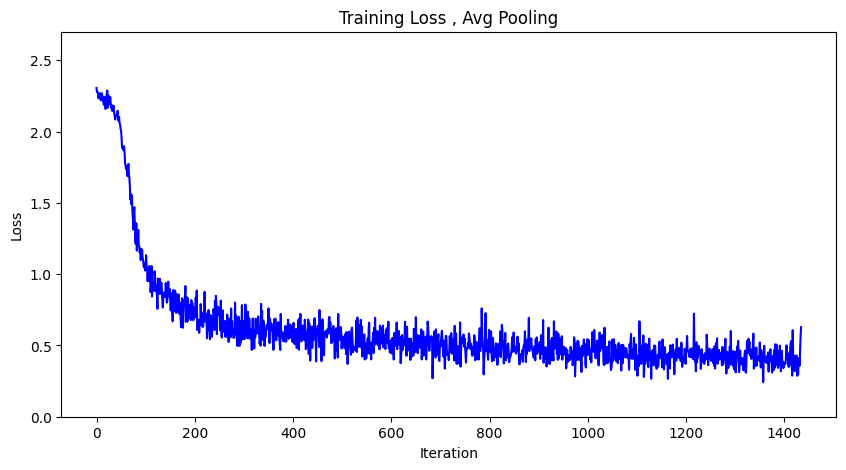

Test Accuracy of the model on the 10000 test images: 86.01336816226183 %


In [ ]:
loss_list = train(CNN, train_loader, optimizer, num_epochs, model_name='model_1_avgpool.ckpt')
plot_loss(loss_list, " , Avg Pooling")

CNN.load_state_dict(torch.load(resultsdir + 'model_1_avgpool.ckpt'))

test_acc = test(CNN, test_loader)

#### 7. Decreasing Filter Counts

In [ ]:
#Going from larger filter sizes to smaller
class TestingConvNet(nn.Module):
    def __init__(self, num_classes=10):

        super(TestingConvNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)  # 32*32*3 --> 32*32*64
        # input : 3 channel, output 64 channel, filter size : 5x5

        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)  # 16*16*64 --> 16*16*32
        # input : 64 channel, output 32 channel, filter size : 3x3

        self.conv3 = nn.Conv2d(32, 16, kernel_size=3, padding=1)  # 8*8*32 --> 8*8*16
        # input : 32 channel, output 16 channel, filter size : 3x3

        self.fc = nn.Linear(4*4*16, num_classes)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.relu = nn.ReLU()

    def forward(self, x):

        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.conv3(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = out.reshape(out.size(0), -1) #128,64,2,2 -> 128,2*2*64
        out = self.fc(out) # we don't need sigmoid or other activation function at the end beacuse we will use nn.CrossEntropyLoss() (check documentation to understand why)

        return out

In [ ]:
CNN = TestingConvNet().to(device)

learning_rate = .001
optimizer = torch.optim.Adam(CNN.parameters(),lr = learning_rate)

num_epochs = 5

Epoch [1/5], Loss: 1.2679
Epoch [2/5], Loss: 0.6057
Epoch [3/5], Loss: 0.5137
Epoch [4/5], Loss: 0.4667
Epoch [5/5], Loss: 0.4324


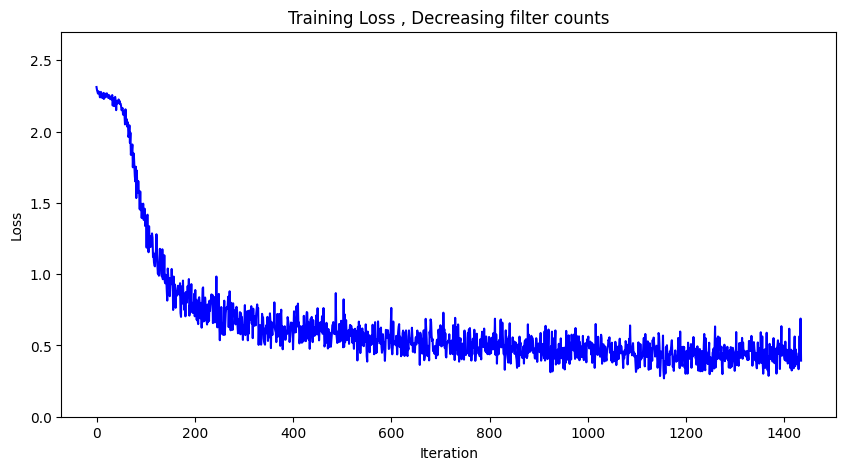

Test Accuracy of the model on the 10000 test images: 85.98263675476336 %


In [ ]:
loss_list = train(CNN, train_loader, optimizer, num_epochs, model_name='model_1_decreasing.ckpt')
plot_loss(loss_list, " , Decreasing filter counts")

CNN.load_state_dict(torch.load(resultsdir + 'model_1_decreasing.ckpt'))

test_acc = test(CNN, test_loader)

#### 8. Regularization

In [ ]:
# Adding Batch Normalization
class TestingConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(TestingConvNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=5,  padding=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3,  padding=1)

        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)

        self.fc = nn.Linear(8*8*32, num_classes)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = out.reshape(out.size(0), -1)  # Flatten
        out = self.fc(out)
        return out


In [ ]:
CNN = TestingConvNet().to(device)

learning_rate = .001
optimizer = torch.optim.Adam(CNN.parameters(),lr = learning_rate)

num_epochs = 5


Epoch [1/5], Loss: 0.9093
Epoch [2/5], Loss: 0.5240
Epoch [3/5], Loss: 0.4648
Epoch [4/5], Loss: 0.4262
Epoch [5/5], Loss: 0.3993


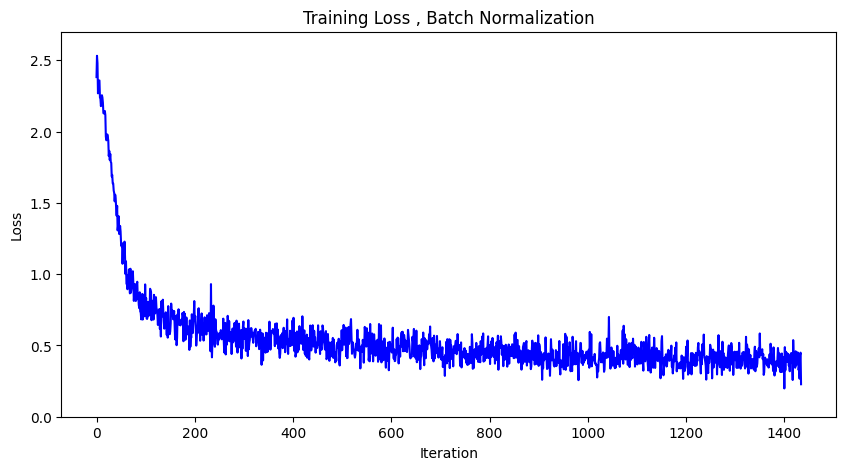

Test Accuracy of the model on the 10000 test images: 86.36677934849416 %


In [ ]:
loss_list = train(CNN, train_loader, optimizer, num_epochs, model_name='model_1_batchnorm.ckpt')

plot_loss(loss_list, " , Batch Normalization")

CNN.load_state_dict(torch.load(resultsdir + 'model_1_batchnorm.ckpt'))

test_acc = test(CNN, test_loader)

In [28]:
# Adding Dropout
class TestingConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(TestingConvNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=5,  padding=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3,  padding=1)

        self.dropout = nn.Dropout2d(p=0.5)

        self.fc = nn.Linear(8*8*32, num_classes)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.dropout(out)

        out = out.reshape(out.size(0), -1)  # Flatten
        out = self.fc(out)
        return out


In [29]:
CNN = TestingConvNet().to(device)

learning_rate = .001
optimizer = torch.optim.Adam(CNN.parameters(),lr = learning_rate)

num_epochs = 5


Epoch [1/5], Loss: 1.1219
Epoch [2/5], Loss: 0.6424
Epoch [3/5], Loss: 0.5822
Epoch [4/5], Loss: 0.5492
Epoch [5/5], Loss: 0.5304


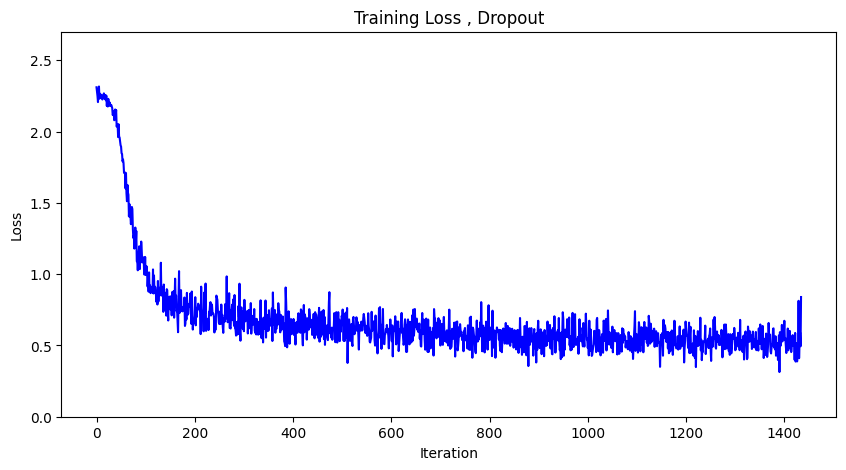

Test Accuracy of the model on the 10000 test images: 85.92885679164105 %


In [30]:
loss_list = train(CNN, train_loader, optimizer, num_epochs, model_name='model_1_dropout.ckpt')

plot_loss(loss_list, " , Dropout")

CNN.load_state_dict(torch.load(resultsdir + 'model_1_dropout.ckpt'))

test_acc = test(CNN, test_loader)

#### 9. Activation Function

In [ ]:
# Testing different activation functions
class TestingConvNet(nn.Module):
    def __init__(self, num_classes=10, activation="relu"):
        super(TestingConvNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=5,  padding=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3,  padding=1)

        self.fc = nn.Linear(8*8*32, num_classes)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        if (activation == "relu"):
            self.act = nn.ReLU()
        elif (activation == "lrelu"):
            self.act = nn.LeakyReLU()
        elif (activation == "prelu"):
            self.act = nn.PReLU()


    def forward(self, x):
        out = self.conv1(x)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.conv2(out)
        out = self.act(out)
        out = self.maxpool(out)

        out = out.reshape(out.size(0), -1)  # Flatten
        out = self.fc(out)
        return out


In [ ]:
activation_functions = ["relu", "lrelu", "prelu"]

learning_rate = .001

num_epochs = 5

Epoch [1/5], Loss: 0.9704
Epoch [2/5], Loss: 0.5413
Epoch [3/5], Loss: 0.4745
Epoch [4/5], Loss: 0.4299
Epoch [5/5], Loss: 0.4004


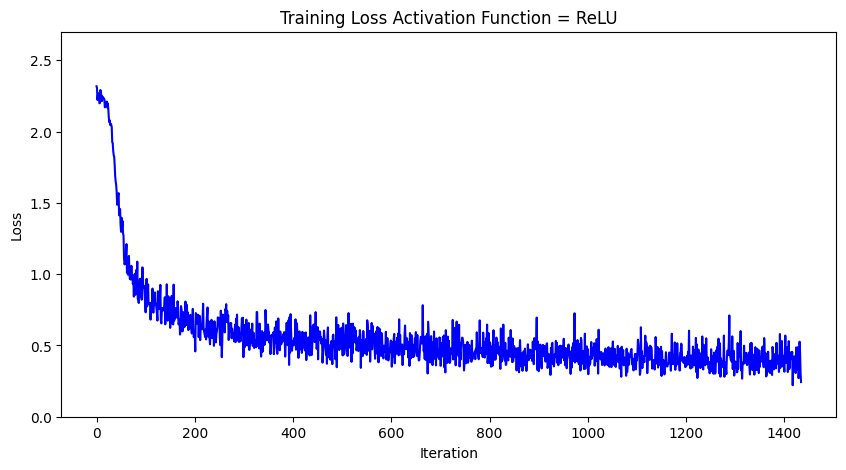

Test Accuracy of the model on the 10000 test images: 86.63183773816841 %
Epoch [1/5], Loss: 0.9448
Epoch [2/5], Loss: 0.5274
Epoch [3/5], Loss: 0.4649
Epoch [4/5], Loss: 0.4233
Epoch [5/5], Loss: 0.3927


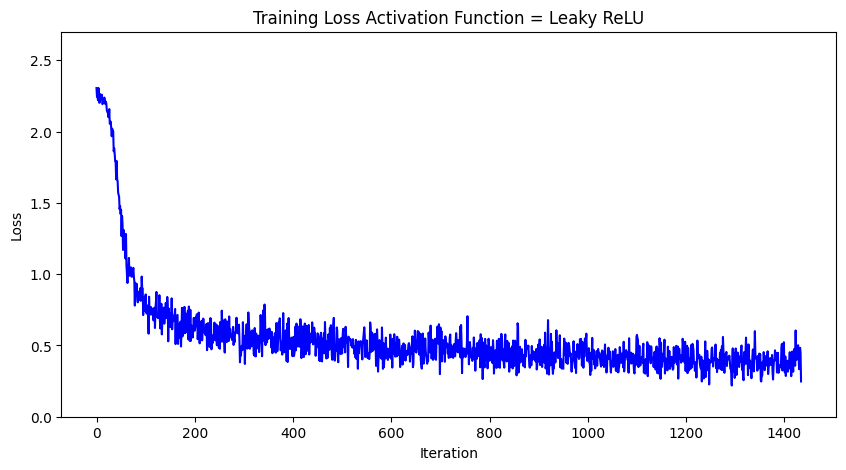

Test Accuracy of the model on the 10000 test images: 86.74708051628765 %
Epoch [1/5], Loss: 1.0175
Epoch [2/5], Loss: 0.5460
Epoch [3/5], Loss: 0.4777
Epoch [4/5], Loss: 0.4316
Epoch [5/5], Loss: 0.3981


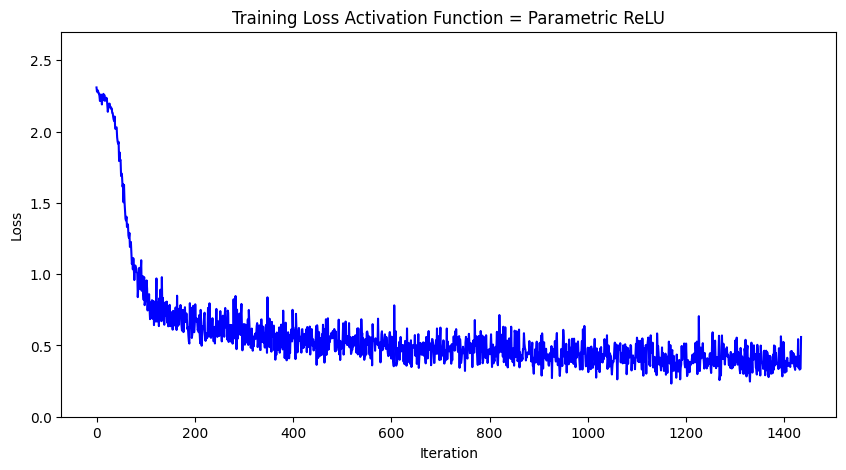

Test Accuracy of the model on the 10000 test images: 86.70098340503995 %


In [ ]:
for i, act in enumerate(activation_functions):

    CNN = TestingConvNet(activation=act).to(device)
    optimizer = torch.optim.Adam(CNN.parameters(),lr = learning_rate)

    loss_list = train(CNN, train_loader, optimizer, num_epochs, model_name='model_1_actfunc' + str(i) + '.ckpt')

    if (act == "relu"):
        function  = "ReLU"
    elif (act == "lrelu"):
        function  = "Leaky ReLU"
    elif (act == "prelu"):
        function  = "Parametric ReLU"


    title = " Activation Function = " + function
    plot_loss(loss_list, title)

    CNN.load_state_dict(torch.load(resultsdir + 'model_1_actfunc' + str(i) + '.ckpt'))

    test_acc = test(CNN, test_loader)

#### 10. Number of Epochs


In [ ]:
CNN = ConvNet().to(device)

learning_rate = .001
optimizer = torch.optim.Adam(CNN.parameters(),lr = learning_rate)

num_epochs = 10

Epoch [1/10], Loss: 1.0354
Epoch [2/10], Loss: 0.5528
Epoch [3/10], Loss: 0.4843
Epoch [4/10], Loss: 0.4440
Epoch [5/10], Loss: 0.4128
Epoch [6/10], Loss: 0.3876
Epoch [7/10], Loss: 0.3668
Epoch [8/10], Loss: 0.3494
Epoch [9/10], Loss: 0.3359
Epoch [10/10], Loss: 0.3225


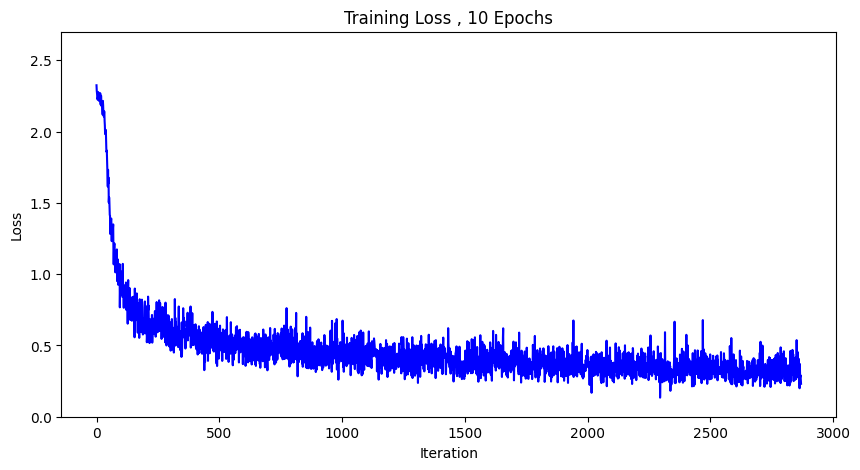

Test Accuracy of the model on the 10000 test images: 87.29256299938537 %


In [ ]:
loss_list = train(CNN, train_loader, optimizer, num_epochs, model_name='model_1_epochs.ckpt')
plot_loss(loss_list, " , 10 Epochs")

CNN.load_state_dict(torch.load(resultsdir + 'model_1_epochs.ckpt'))

test_acc = test(CNN, test_loader)

## Final Model

In [32]:
class FinalConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(FinalConvNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3,  padding=1) # (32 + 2*1 - 3) + 1 = 32
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3,  padding=1) # (32 + 2*1 - 3) + 1 = 32
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3,  padding=1) # (16 + 2*1 - 3) + 1 = 16
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3,  padding=1) # (16 + 2*1 - 3) + 1 = 16

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout = nn.Dropout(p=0.3)

        self.fc = nn.Linear(8*8*64, num_classes)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.activation = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x) # shape (32, 32, 32)
        out = self.activation(out) # (32, 32, 32)
        out = self.bn1(out) # (32, 32, 32)

        out = self.conv2(out) # (32, 32, 32)
        out = self.activation(out) # (32, 32, 32)
        out = self.maxpool(out) # (16, 16, 32)
        out = self.dropout(out) # (16, 16, 32)

        out = self.conv3(out) # (16, 16, 64)
        out = self.activation(out) # (16, 16, 64)
        out = self.bn2(out) # (16, 16, 64)

        out = self.conv4(out) # (16, 16, 64)
        out = self.activation(out) # (16, 16, 64)
        out = self.maxpool(out) # (8, 8, 64)
        out = self.dropout(out)

        out = out.reshape(out.size(0), -1)  # Flatten
        out = self.fc(out)
        return out

In [33]:
# FINAL PARAMETERS

activation_function = "ReLU"
pooling_method = "Max Pool"
batch_normalization = True
learning_rate = .001
num_epochs = 10

CNN = FinalConvNet().to(device)
optimizer = torch.optim.Adam(CNN.parameters(), lr = learning_rate)

Epoch [1/10], Loss: 0.8407
Epoch [2/10], Loss: 0.4020
Epoch [3/10], Loss: 0.3315
Epoch [4/10], Loss: 0.2969
Epoch [5/10], Loss: 0.2726
Epoch [6/10], Loss: 0.2516
Epoch [7/10], Loss: 0.2377
Epoch [8/10], Loss: 0.2261
Epoch [9/10], Loss: 0.2169
Epoch [10/10], Loss: 0.2091


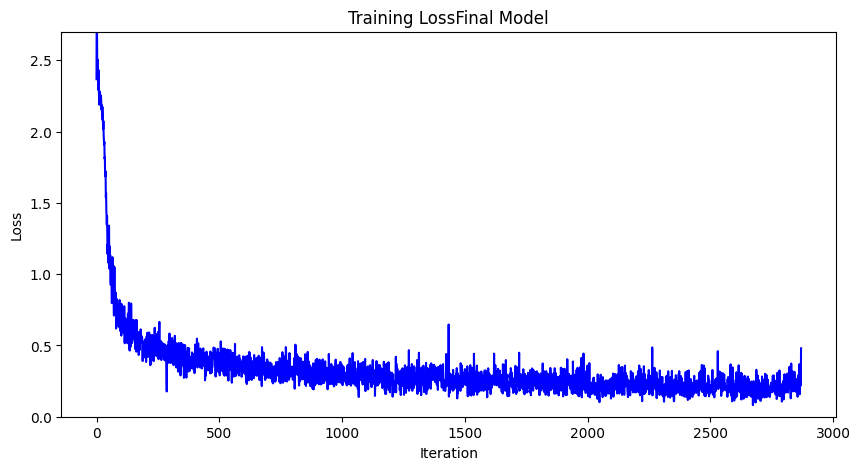

Test Accuracy of the model on the 10000 test images: 92.88183773816841 %


In [34]:
loss_list = train(CNN, train_loader, optimizer, num_epochs, model_name='model_1_final.ckpt')
plot_loss(loss_list, "Final Model")

CNN.load_state_dict(torch.load(resultsdir + 'model_1_final.ckpt'))

test_acc = test(CNN, test_loader)

# Ex. 2

## **Building your own efficient Convolutional Network architecture for SVHN**

In the following,  you will need to build your own CNN architecture to predict digit numbers on the SVHN dataset. You are completely free to use any kind of layers and hyper-parameters for this purpose. Your goal is to acheive the maximum possible accuracy on the test set (the better, the higher score you'll get in the exercice). The only constraint is that your model should not contain more than 150K parameters. Below, we provide a simple code to compute the number of parameters in a model.

## Computing model parameters

In [35]:
# Compute model paramters
def compute_model_params(model):
  params = 0
  for p in model.parameters():
    params+= p.numel()
  return params

1. Design and implement your own CNN. Given that the number of parameters must be small, you can check some papers focused on efficient CNN architectures and get some ideas.
  - MobileNet: https://arxiv.org/abs/1704.04861
  - MobileNet V2: https://arxiv.org/pdf/1801.04381.pdf
  - SqueezeNet: https://arxiv.org/abs/1602.07360
  - ShuffleNet: https://arxiv.org/abs/1707.01083
  - ESPNet V2: https://arxiv.org/abs/1811.11431
2. Train it and test it on SVHN using the provided code.
3. Discuss what approaches have you tried, why, and which ones have shown to be more beneficial.

# Sol. 2

## Define your own model and check the number of total parameters

In [36]:
# Mobilenet Style Architecture
class MyModel(nn.Module):
    def __init__(self, num_classes=10):
        super(MyModel, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, groups=32)
        self.bn2 = nn.BatchNorm2d(32)
        self.pointwise1 = nn.Conv2d(32, 64, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, groups=64)
        self.bn4 = nn.BatchNorm2d(64)
        self.pointwise2 = nn.Conv2d(64, 128, kernel_size=1, stride=1, padding=0)
        self.bn5 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, groups=128)
        self.bn6 = nn.BatchNorm2d(128)
        self.pointwise3 = nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0)
        self.bn7 = nn.BatchNorm2d(128)
        
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1, groups=128)
        self.bn8 = nn.BatchNorm2d(128)
        self.pointwise4 = nn.Conv2d(128, 256, kernel_size=1, stride=1, padding=0)
        self.bn9 = nn.BatchNorm2d(256)
        
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, groups=256)
        self.bn10 = nn.BatchNorm2d(256)
        self.pointwise5 = nn.Conv2d(256, 256, kernel_size=1, stride=2, padding=0)
        self.bn11 = nn.BatchNorm2d(256)

        self.linear = nn.Linear(256, num_classes)
        self.avgpool= nn.AvgPool2d(kernel_size=4, stride=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.relu(self.bn3(self.pointwise1(out)))

        out = self.relu(self.bn4(self.conv3(out)))
        out = self.relu(self.bn5(self.pointwise2(out)))

        out = self.relu(self.bn6(self.conv4(out)))
        out = self.relu(self.bn7(self.pointwise3(out)))

        out = self.relu(self.bn8(self.conv5(out)))
        out = self.relu(self.bn9(self.pointwise4(out)))

        out = self.relu(self.bn10(self.conv6(out)))
        out = self.relu(self.bn11(self.pointwise5(out)))

        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        
        return out

model = MyModel(num_classes=10)
n_params = compute_model_params(model)
print("MyModel Parameters: " + str(n_params))
assert n_params < 150000

MyModel Parameters: 138250


## Train your model on SVHN
It is not allowed to change training hyper-parameters such as learning rate, batch size or number of epochs. You can only modify the architecture definition.

In [59]:
# Train function
def train(CNN, train_loader, optimizer, num_epochs=5, model_name='model.ckpt', device='cpu'):
    CNN.train() # Set the model in train mode
    total_step = len(train_loader)
    losses_list = []
    criterion = nn.CrossEntropyLoss()
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        loss_avg = 0
        nBatches = 0
        for i, (images, labels) in enumerate(train_loader):
            # Get batch of samples and labels
            images = images.to(device)
            labels = labels.type(torch.LongTensor).to(device)

            # Forward pass
            outputs = CNN(images)
            loss = criterion(outputs, labels-1)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_avg += loss.cpu().item()
            nBatches+=1
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        losses_list.append(loss_avg / nBatches)
        torch.save(CNN.state_dict(), resultsdir + '/' + model_name)

    return losses_list

# Test funcion
def test(CNN, test_loader):
  with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            # get network predictions
            outputs = CNN(images)

            # get predicted class
            _, predicted = torch.max(outputs.data, 1)

            # compare with the ground-truth
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # return accuracy
        return 100 * correct / total

In [38]:
#Train MyModel
my_model = MyModel()

#Initialize optimizer
learning_rate = .1
optimizer = torch.optim.SGD(my_model.parameters(),lr = learning_rate,
                            weight_decay=1e-5, momentum=0.9)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
my_model = my_model.to(device)

losses_list = train(my_model, train_loader, optimizer, num_epochs=10, model_name='my_net.ckpt', device=device)

Epoch [1/10], Step [100/287], Loss: 1.8908
Epoch [1/10], Step [200/287], Loss: 1.3919
Epoch [1/10], Step [287/287], Loss: 1.1266
Epoch [2/10], Step [100/287], Loss: 0.4059
Epoch [2/10], Step [200/287], Loss: 0.3923
Epoch [2/10], Step [287/287], Loss: 0.3735
Epoch [3/10], Step [100/287], Loss: 0.2970
Epoch [3/10], Step [200/287], Loss: 0.2900
Epoch [3/10], Step [287/287], Loss: 0.2887
Epoch [4/10], Step [100/287], Loss: 0.2421
Epoch [4/10], Step [200/287], Loss: 0.2476
Epoch [4/10], Step [287/287], Loss: 0.2472
Epoch [5/10], Step [100/287], Loss: 0.2068
Epoch [5/10], Step [200/287], Loss: 0.2129
Epoch [5/10], Step [287/287], Loss: 0.2183
Epoch [6/10], Step [100/287], Loss: 0.1954
Epoch [6/10], Step [200/287], Loss: 0.1938
Epoch [6/10], Step [287/287], Loss: 0.1948
Epoch [7/10], Step [100/287], Loss: 0.1685
Epoch [7/10], Step [200/287], Loss: 0.1697
Epoch [7/10], Step [287/287], Loss: 0.1733
Epoch [8/10], Step [100/287], Loss: 0.1461
Epoch [8/10], Step [200/287], Loss: 0.1521
Epoch [8/10

## Test your model
As a reference, 93% of accuracy can be easily achieved by using only ~55000 parameters.

In [40]:
# Show results for all the trained models
SVHNTest = SVHN(datadir + 'svhn/test_32x32.mat',tr)
test_loader = torch.utils.data.DataLoader(dataset=SVHNTest,
                                               batch_size=256, 
                                               shuffle=True)

my_net = MyModel()
my_net.load_state_dict(torch.load(resultsdir + 'my_net.ckpt'))
my_net.to(device)
acc = test(my_net, test_loader)
print('Accuracy MyNet: ' + str(acc) + '%.')

Accuracy MyNet: 91.44514443761524%.


# Ex. 3

1. Use the implemented architecture in the previous exercise to solve the transfer learning
   task provided in the examples.
2. Try to fine-tune not only the last layer for the CNN but a larger subset of parameters.
2. Report the test accuracy in each case and discuss the results.

# Sol. 3

## Initialize DataLoaders for Transfer Learning experiment

In [51]:
# Create train data loader
tr = tf.Compose([
        tf.ToTensor(), 
        tf.Normalize(mean = [.5], std = [.5])
        ])

# Big dataset with numbers from 1 to 8
SVHNTrain_TL = SVHN(datadir + '/svhn_tl/tl_train_32x32.mat', tr)
tl_train_loader = torch.utils.data.DataLoader(dataset=SVHNTrain_TL,
                                               batch_size=256,
                                               shuffle=True)

# 200 samples of 0s and 9s
SVHNTrain_TL_0_9 = SVHN(datadir + '/svhn_tl/tl_train_9_10_32x32.mat',tr)
tl_train_loader_0_9 = torch.utils.data.DataLoader(dataset=SVHNTrain_TL_0_9,
                                                  batch_size=64,
                                                  shuffle=True)
# Test dataset with 0 and 9s
SVHNTest_TL_0_9 = SVHN(datadir + '/svhn_tl/tl_test_9_10_32x32.mat',tr)
tl_test_loader_0_9 = torch.utils.data.DataLoader(dataset=SVHNTest_TL_0_9,
                                                  batch_size=64,
                                                  shuffle=True)

## Pre-train your model with the big dataset with numbers from 1 to 8

In [60]:
#Train ResNet
resnet_tl = MyModel(num_classes=8)

#Initialize optimizer
learning_rate = .1
optimizer = torch.optim.SGD(resnet_tl.parameters(), lr = learning_rate, weight_decay=1e-5, momentum=0.9)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
resnet_tl = resnet_tl.to(device)

losses_it = train(resnet_tl, tl_train_loader, optimizer, num_epochs=10, model_name='tl_mynet_svhn.ckpt', device=device)

Epoch [1/10], Step [100/249], Loss: 1.7026
Epoch [1/10], Step [200/249], Loss: 1.2234
Epoch [1/10], Step [249/249], Loss: 1.0751


KeyboardInterrupt: 

## Fine-tune the pretrained network with the small dataset of 9s and 0s

In [ ]:
resnet_tl = MyModel(num_classes=8)
resnet_tl.load_state_dict(torch.load(resultsdir + 'tl_resnet_svhn.ckpt'))

resnet_tl.fc = nn.Linear(8*8*64, 2)
resnet_tl = resnet_tl.to(device)

# printea cosas guapas, habria q mirar el input size q creo q esta bien but not sure
torchsummary.summary(resnet_tl, input_size = (3,32,32))

learning_rate = .01
# need to choose better optimizer?
optimizer = torch.optim.SGD(resnet_tl.fc.parameters(),lr = learning_rate, weight_decay=1e-5, momentum=0.9)

losses_list = train(resnet_tl, tl_train_loader_0_9, optimizer, num_epochs=20, model_name='tl_resnet_finetuned_svhn.ckpt', device=device)
acc = test(resnet_tl, tl_test_loader_0_9)
print('Accuracy ResNet Transfer Learning: ' + str(acc))